# Regression Week 4: Ridge Regression (gradient descent)

In this notebook, you will implement ridge regression via gradient descent. You will:
* Convert an SFrame into a Numpy array
* Write a Numpy function to compute the derivative of the regression weights with respect to a single feature
* Write gradient descent function to compute the regression weights given an initial weight vector, step size, tolerance, and L2 penalty

# Fire up Turi Create

Make sure you have the latest version of Turi Create

In [1]:
#import turicreate
import pandas as pd

# Load in house sales data

Dataset is from house sales in King County, the region where the city of Seattle, WA is located.

In [2]:
sales = pd.read_csv('kc_house_data.csv')
sales.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


If we want to do any "feature engineering" like creating new features or adjusting existing ones we should do this directly using the SFrames as seen in the first notebook of Week 2. For this notebook, however, we will work with the existing features.

# Import useful functions from previous notebook

As in Week 2, we convert the SFrame into a 2D Numpy array. Copy and paste `get_numpy_data()` from the second notebook of Week 2.

In [3]:
import numpy as np # note this allows us to refer to numpy as np instead 

In [4]:
train_data=pd.read_csv("kc_house_train_data.csv")
test_data=pd.read_csv("kc_house_test_data.csv")
def get_numpy_data(data_sframe, features, output):
    data_sframe['constant'] = 1 # this is how you add a constant column to an SFrame
    # add the column 'constant' to the front of the features list so that we can extract it along with the others:
    features = ['constant'] + features # this is how you combine two lists
    # select the columns of data_SFrame given by the features list into the SFrame features_sframe (now including constant):

    # the following line will convert the features_SFrame into a numpy matrix:
    feature_matrix = np.array(data_sframe[features])#features_sframe.to_numpy()
    # assign the column of data_sframe associated with the output to the SArray output_sarray

    # the following will convert the SArray into a numpy array by first converting it to a list
    output_array = np.array(data_sframe[output])#output_sarray.to_numpy()
    return(feature_matrix, output_array)

Also, copy and paste the `predict_output()` function to compute the predictions for an entire matrix of features given the matrix and the weights:

In [5]:
def predict_output(feature_matrix, weights):
    # assume feature_matrix is a numpy matrix containing the features as columns and weights is a corresponding numpy array
    # create the predictions vector by using np.dot()
    predictions=np.dot(feature_matrix,weights)
    return(predictions)

# Computing the Derivative

We are now going to move to computing the derivative of the regression cost function. Recall that the cost function is the sum over the data points of the squared difference between an observed output and a predicted output, plus the L2 penalty term.
```
Cost(w)
= SUM[ (prediction - output)^2 ]
+ l2_penalty*(w[0]^2 + w[1]^2 + ... + w[k]^2).
```

Since the derivative of a sum is the sum of the derivatives, we can take the derivative of the first part (the RSS) as we did in the notebook for the unregularized case in Week 2 and add the derivative of the regularization part.  As we saw, the derivative of the RSS with respect to `w[i]` can be written as: 
```
2*SUM[ error*[feature_i] ].
```
The derivative of the regularization term with respect to `w[i]` is:
```
2*l2_penalty*w[i].
```
Summing both, we get
```
2*SUM[ error*[feature_i] ] + 2*l2_penalty*w[i].
```
That is, the derivative for the weight for feature i is the sum (over data points) of 2 times the product of the error and the feature itself, plus `2*l2_penalty*w[i]`. 

**We will not regularize the constant.**  Thus, in the case of the constant, the derivative is just twice the sum of the errors (without the `2*l2_penalty*w[0]` term).

Recall that twice the sum of the product of two vectors is just twice the dot product of the two vectors. Therefore the derivative for the weight for feature_i is just two times the dot product between the values of feature_i and the current errors, plus `2*l2_penalty*w[i]`.

With this in mind complete the following derivative function which computes the derivative of the weight given the value of the feature (over all data points) and the errors (over all data points).  To decide when to we are dealing with the constant (so we don't regularize it) we added the extra parameter to the call `feature_is_constant` which you should set to `True` when computing the derivative of the constant and `False` otherwise.

In [6]:
def feature_derivative_ridge(errors, feature, weight, l2_penalty, feature_is_constant):
    # If feature_is_constant is True, derivative is twice the dot product of errors and feature
    # Otherwise, derivative is twice the dot product plus 2*l2_penalty*weight
    if feature_is_constant == True:
        return 2*np.sum(errors*feature)
    else:
        return 2*np.sum(errors*feature)+2*l2_penalty*weight

To test your feature derivartive run the following:

In [7]:
import numpy as np
(example_features, example_output) = get_numpy_data(sales, ['sqft_living'], 'price') 
my_weights = np.array([1., 10.])
test_predictions = predict_output(example_features, my_weights) 
errors = test_predictions - example_output # prediction errors

# next two lines should print the same values
print (feature_derivative_ridge(errors, example_features[:,1], my_weights[1], 1, False))
print (np.sum(errors*example_features[:,1])*2+20)
print ('')

# next two lines should print the same values
print (feature_derivative_ridge(errors, example_features[:,0], my_weights[0], 1, True))
print (np.sum(errors)*2)

-56554166815950.0
-56554166815950.0

-22446749330.0
-22446749330.0


# Gradient Descent

Now we will write a function that performs a gradient descent. The basic premise is simple. Given a starting point we update the current weights by moving in the negative gradient direction. Recall that the gradient is the direction of *increase* and therefore the negative gradient is the direction of *decrease* and we're trying to *minimize* a cost function. 

The amount by which we move in the negative gradient *direction*  is called the 'step size'. We stop when we are 'sufficiently close' to the optimum. Unlike in Week 2, this time we will set a **maximum number of iterations** and take gradient steps until we reach this maximum number. If no maximum number is supplied, the maximum should be set 100 by default. (Use default parameter values in Python.)

With this in mind, complete the following gradient descent function below using your derivative function above. For each step in the gradient descent, we update the weight for each feature before computing our stopping criteria.

In [8]:
def ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations=100):
    print ('Starting gradient descent with l2_penalty = ' + str(l2_penalty))
    
    weights = np.array(initial_weights) # make sure it's a numpy array
    iteration = 0 # iteration counter
    print_frequency = 1  # for adjusting frequency of debugging output
    
    #while not reached maximum number of iterations:
    while iteration <=max_iterations:
        iteration += 1  # increment iteration counter
        ### === code section for adjusting frequency of debugging output. ===
        if iteration == 10:
            print("frequency = 10")
        if iteration == 100:
            print("frequency = 100")
        if iteration%print_frequency==0:
            print('Iteration = ' + str(iteration))
        # compute the predictions based on feature_matrix and weights using your predict_output() function
        prediction=predict_output(feature_matrix, weights)
        # compute the errors as predictions - output
        errors=prediction-output
        # from time to time, print the value of the cost function
        if iteration%print_frequency==0:
            print ('Cost function = ', str(np.dot(errors,errors) + l2_penalty*(np.dot(weights,weights) - weights[0]**2)))
        for i in range(len(weights)): # loop over each weight
            # Recall that feature_matrix[:,i] is the feature column associated with weights[i]
            # compute the derivative for weight[i].
            #(Remember: when i=0, you are computing the derivative of the constant!)
            derivative=feature_derivative_ridge(errors,feature_matrix[:,i], weights[i], l2_penalty, False)
            # subtract the step size times the derivative from the current weight
            weights[i]=weights[i]-derivative*step_size
    print ('Done with gradient descent at iteration ', iteration)
    print ('Learned weights = ', str(weights))
    return weights

# Visualizing effect of L2 penalty

The L2 penalty gets its name because it causes weights to have small L2 norms than otherwise. Let's see how large weights get penalized. Let us consider a simple model with 1 feature:

In [9]:
simple_features = ['sqft_living']
my_output = 'price'

Let us split the dataset into training set and test set. Make sure to use `seed=0`:

In [10]:
#train_data,test_data = sales.random_split(.8,seed=0)

In this part, we will only use `'sqft_living'` to predict `'price'`. Use the `get_numpy_data` function to get a Numpy versions of your data with only this feature, for both the `train_data` and the `test_data`. 

In [11]:
(simple_feature_matrix, output) = get_numpy_data(train_data, simple_features, my_output)
(simple_test_feature_matrix, test_output) = get_numpy_data(test_data, simple_features, my_output)

Let's set the parameters for our optimization:

In [12]:
initial_weights = np.array([0., 0.])
step_size = 1e-12
max_iterations=1000

First, let's consider no regularization.  Set the `l2_penalty` to `0.0` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`simple_weights_0_penalty`

we'll use them later.

In [13]:
simple_weights_0_penalty=ridge_regression_gradient_descent(simple_feature_matrix, output,initial_weights, step_size, l2_penalty=0, max_iterations=100)

Starting gradient descent with l2_penalty = 0
Iteration = 1
Cost function =  7433051852335772.0
Iteration = 2
Cost function =  5394267213533688.0
Iteration = 3
Cost function =  4023237736286403.0
Iteration = 4
Cost function =  3101256183295487.0
Iteration = 5
Cost function =  2481247643601011.5
Iteration = 6
Cost function =  2064308076801447.0
Iteration = 7
Cost function =  1783927096156441.0
Iteration = 8
Cost function =  1595378201854742.0
Iteration = 9
Cost function =  1468583989698184.5
frequency = 10
Iteration = 10
Cost function =  1383318190090050.5
Iteration = 11
Cost function =  1325979164434681.2
Iteration = 12
Cost function =  1287420165646444.0
Iteration = 13
Cost function =  1261490244951034.8
Iteration = 14
Cost function =  1244053049777434.5
Iteration = 15
Cost function =  1232326990940044.2
Iteration = 16
Cost function =  1224441522283865.0
Iteration = 17
Cost function =  1219138750322648.8
Iteration = 18
Cost function =  1215572774505631.0
Iteration = 19
Cost function =

Next, let's consider high regularization.  Set the `l2_penalty` to `1e11` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`simple_weights_high_penalty`

we'll use them later.

In [14]:
simple_weights_high_penalty=ridge_regression_gradient_descent(simple_feature_matrix, output,initial_weights, step_size, l2_penalty=1e11, max_iterations=100)

Starting gradient descent with l2_penalty = 100000000000.0
Iteration = 1
Cost function =  7433051852335772.0
Iteration = 2
Cost function =  5618303898910948.0
Iteration = 3
Cost function =  4920613327836153.0
Iteration = 4
Cost function =  4652382056353857.0
Iteration = 5
Cost function =  4549258949620441.0
Iteration = 6
Cost function =  4509612654569464.0
Iteration = 7
Cost function =  4494370397124782.5
Iteration = 8
Cost function =  4488510417904798.0
Iteration = 9
Cost function =  4486257512209394.0
frequency = 10
Iteration = 10
Cost function =  4485391368044055.0
Iteration = 11
Cost function =  4485058373049658.0
Iteration = 12
Cost function =  4484930350718128.5
Iteration = 13
Cost function =  4484881131529001.0
Iteration = 14
Cost function =  4484862208787921.0
Iteration = 15
Cost function =  4484854933762414.5
Iteration = 16
Cost function =  4484852136808385.0
Iteration = 17
Cost function =  4484851061496575.0
Iteration = 18
Cost function =  4484850648091287.0
Iteration = 19
Co

This code will plot the two learned models.  (The blue line is for the model with no regularization and the red line is for the one with high regularization.)

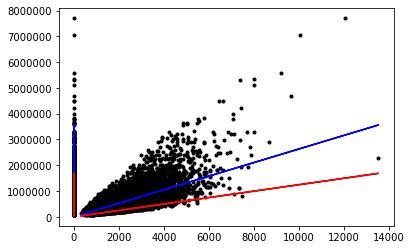

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(simple_feature_matrix,output,'k.',
         simple_feature_matrix,predict_output(simple_feature_matrix, simple_weights_0_penalty),'b-',
        simple_feature_matrix,predict_output(simple_feature_matrix, simple_weights_high_penalty),'r-')

Compute the RSS on the TEST data for the following three sets of weights:
1. The initial weights (all zeros)
2. The weights learned with no regularization
3. The weights learned with high regularization

Which weights perform best?

In [20]:
predict_1=predict_output(simple_test_feature_matrix,[0]*simple_test_feature_matrix.shape[1])
RSS1=np.sum((predict_1-test_output)**2)
RSS1

1784273286136298.0

In [21]:
predict_2=predict_output(simple_test_feature_matrix,simple_weights_0_penalty)
RSS2=np.sum((predict_2-test_output)**2)
RSS2

275723641479196.94

In [22]:
predict_3=predict_output(simple_test_feature_matrix,simple_weights_high_penalty)
RSS3=np.sum((predict_3-test_output)**2)
RSS3

694654309578539.5

In [23]:
min(RSS1,RSS2,RSS3)

275723641479196.94

***QUIZ QUESTIONS***
1. What is the value of the coefficient for `sqft_living` that you learned with no regularization, rounded to 1 decimal place?  What about the one with high regularization?
2. Comparing the lines you fit with the with no regularization versus high regularization, which one is steeper?
3. What are the RSS on the test data for each of the set of weights above (initial, no regularization, high regularization)? 


# Running a multiple regression with L2 penalty

Let us now consider a model with 2 features: `['sqft_living', 'sqft_living15']`.

First, create Numpy versions of your training and test data with these two features. 

In [24]:
model_features = ['sqft_living', 'sqft_living15'] # sqft_living15 is the average squarefeet for the nearest 15 neighbors. 
my_output = 'price'
(feature_matrix, output) = get_numpy_data(train_data, model_features, my_output)
(test_feature_matrix, test_output) = get_numpy_data(test_data, model_features, my_output)

We need to re-inialize the weights, since we have one extra parameter. Let us also set the step size and maximum number of iterations.

In [25]:
initial_weights = np.array([0.0,0.0,0.0])
step_size = 1e-12
max_iterations = 1000
l2_penalty=0

First, let's consider no regularization.  Set the `l2_penalty` to `0.0` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`multiple_weights_0_penalty`

In [26]:
multiple_weights_0_penalty=ridge_regression_gradient_descent(feature_matrix,output,initial_weights,step_size,l2_penalty, max_iterations)

Starting gradient descent with l2_penalty = 0
Iteration = 1
Cost function =  7433051852335772.0
Iteration = 2
Cost function =  4056752332045942.5
Iteration = 3
Cost function =  2529565114525309.5
Iteration = 4
Cost function =  1838556694300507.0
Iteration = 5
Cost function =  1525675575150296.5
Iteration = 6
Cost function =  1383789498571783.8
Iteration = 7
Cost function =  1319232606146273.5
Iteration = 8
Cost function =  1289648871879140.8
Iteration = 9
Cost function =  1275884723913737.0
frequency = 10
Iteration = 10
Cost function =  1269278807397619.2
Iteration = 11
Cost function =  1265914378765985.2
Iteration = 12
Cost function =  1264020221934020.5
Iteration = 13
Cost function =  1262795335132442.8
Iteration = 14
Cost function =  1261877450914050.0
Iteration = 15
Cost function =  1261102699368010.0
Iteration = 16
Cost function =  1260396927128329.8
Iteration = 17
Cost function =  1259726551510372.0
Iteration = 18
Cost function =  1259076336603221.5
Iteration = 19
Cost function =

Iteration = 183
Cost function =  1213113432442678.0
Iteration = 184
Cost function =  1213024652635975.5
Iteration = 185
Cost function =  1212936922912050.8
Iteration = 186
Cost function =  1212850230850562.2
Iteration = 187
Cost function =  1212764564178075.0
Iteration = 188
Cost function =  1212679910766325.0
Iteration = 189
Cost function =  1212596258630499.2
Iteration = 190
Cost function =  1212513595927542.0
Iteration = 191
Cost function =  1212431910954476.0
Iteration = 192
Cost function =  1212351192146747.2
Iteration = 193
Cost function =  1212271428076585.8
Iteration = 194
Cost function =  1212192607451390.0
Iteration = 195
Cost function =  1212114719112125.5
Iteration = 196
Cost function =  1212037752031747.8
Iteration = 197
Cost function =  1211961695313639.0
Iteration = 198
Cost function =  1211886538190067.0
Iteration = 199
Cost function =  1211812270020659.0
Iteration = 200
Cost function =  1211738880290897.0
Iteration = 201
Cost function =  1211666358610627.5
Iteration = 

Cost function =  1206577120931126.0
Iteration = 356
Cost function =  1206565652104690.5
Iteration = 357
Cost function =  1206554318929494.8
Iteration = 358
Cost function =  1206543119801060.5
Iteration = 359
Cost function =  1206532053133887.5
Iteration = 360
Cost function =  1206521117361229.0
Iteration = 361
Cost function =  1206510310934868.5
Iteration = 362
Cost function =  1206499632324903.5
Iteration = 363
Cost function =  1206489080019525.5
Iteration = 364
Cost function =  1206478652524809.0
Iteration = 365
Cost function =  1206468348364497.2
Iteration = 366
Cost function =  1206458166079795.2
Iteration = 367
Cost function =  1206448104229163.2
Iteration = 368
Cost function =  1206438161388111.0
Iteration = 369
Cost function =  1206428336148997.0
Iteration = 370
Cost function =  1206418627120830.5
Iteration = 371
Cost function =  1206409032929071.8
Iteration = 372
Cost function =  1206399552215440.5
Iteration = 373
Cost function =  1206390183637720.5
Iteration = 374
Cost functio

Iteration = 536
Cost function =  1205720008523256.2
Iteration = 537
Cost function =  1205718677296392.5
Iteration = 538
Cost function =  1205717361813599.2
Iteration = 539
Cost function =  1205716061888656.8
Iteration = 540
Cost function =  1205714777337547.0
Iteration = 541
Cost function =  1205713507978428.5
Iteration = 542
Cost function =  1205712253631611.5
Iteration = 543
Cost function =  1205711014119531.0
Iteration = 544
Cost function =  1205709789266722.0
Iteration = 545
Cost function =  1205708578899795.0
Iteration = 546
Cost function =  1205707382847412.0
Iteration = 547
Cost function =  1205706200940260.5
Iteration = 548
Cost function =  1205705033011031.8
Iteration = 549
Cost function =  1205703878894395.2
Iteration = 550
Cost function =  1205702738426976.0
Iteration = 551
Cost function =  1205701611447331.2
Iteration = 552
Cost function =  1205700497795928.5
Iteration = 553
Cost function =  1205699397315122.2
Iteration = 554
Cost function =  1205698309849129.8
Iteration = 

Iteration = 746
Cost function =  1205616691935977.8
Iteration = 747
Cost function =  1205616582391029.2
Iteration = 748
Cost function =  1205616474140141.0
Iteration = 749
Cost function =  1205616367168007.2
Iteration = 750
Cost function =  1205616261459502.5
Iteration = 751
Cost function =  1205616156999681.0
Iteration = 752
Cost function =  1205616053773772.8
Iteration = 753
Cost function =  1205615951767183.5
Iteration = 754
Cost function =  1205615850965491.2
Iteration = 755
Cost function =  1205615751354444.5
Iteration = 756
Cost function =  1205615652919960.2
Iteration = 757
Cost function =  1205615555648122.0
Iteration = 758
Cost function =  1205615459525178.2
Iteration = 759
Cost function =  1205615364537540.0
Iteration = 760
Cost function =  1205615270671778.5
Iteration = 761
Cost function =  1205615177914624.5
Iteration = 762
Cost function =  1205615086252965.5
Iteration = 763
Cost function =  1205614995673844.0
Iteration = 764
Cost function =  1205614906164455.2
Iteration = 

Iteration = 927
Cost function =  1205608490657697.5
Iteration = 928
Cost function =  1205608477821526.2
Iteration = 929
Cost function =  1205608465135547.2
Iteration = 930
Cost function =  1205608452597984.2
Iteration = 931
Cost function =  1205608440207081.8
Iteration = 932
Cost function =  1205608427961104.5
Iteration = 933
Cost function =  1205608415858339.5
Iteration = 934
Cost function =  1205608403897091.5
Iteration = 935
Cost function =  1205608392075687.5
Iteration = 936
Cost function =  1205608380392473.2
Iteration = 937
Cost function =  1205608368845814.5
Iteration = 938
Cost function =  1205608357434095.5
Iteration = 939
Cost function =  1205608346155720.5
Iteration = 940
Cost function =  1205608335009112.0
Iteration = 941
Cost function =  1205608323992712.2
Iteration = 942
Cost function =  1205608313104980.5
Iteration = 943
Cost function =  1205608302344394.8
Iteration = 944
Cost function =  1205608291709451.5
Iteration = 945
Cost function =  1205608281198664.8
Iteration = 

Next, let's consider high regularization.  Set the `l2_penalty` to `1e11` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`multiple_weights_high_penalty`

In [27]:
l2_penalty=1e11
multiple_weights_high_penalty=ridge_regression_gradient_descent(feature_matrix,output,initial_weights,step_size,l2_penalty, max_iterations)

Starting gradient descent with l2_penalty = 100000000000.0
Iteration = 1
Cost function =  7433051852335772.0
Iteration = 2
Cost function =  4460489790922030.5
Iteration = 3
Cost function =  3796674504591489.0
Iteration = 4
Cost function =  3648319602094899.0
Iteration = 5
Cost function =  3615091213565494.0
Iteration = 6
Cost function =  3607602894633405.0
Iteration = 7
Cost function =  3605886518090020.0
Iteration = 8
Cost function =  3605475115347710.0
Iteration = 9
Cost function =  3605365453947494.0
frequency = 10
Iteration = 10
Cost function =  3605329733905938.0
Iteration = 11
Cost function =  3605314672328754.0
Iteration = 12
Cost function =  3605306840959766.5
Iteration = 13
Cost function =  3605302274791217.5
Iteration = 14
Cost function =  3605299478669817.0
Iteration = 15
Cost function =  3605297734164727.5
Iteration = 16
Cost function =  3605296638350463.0
Iteration = 17
Cost function =  3605295948344469.0
Iteration = 18
Cost function =  3605295513495321.0
Iteration = 19
Co

Cost function =  3605294771762630.0
Iteration = 191
Cost function =  3605294771762630.0
Iteration = 192
Cost function =  3605294771762630.0
Iteration = 193
Cost function =  3605294771762630.0
Iteration = 194
Cost function =  3605294771762630.0
Iteration = 195
Cost function =  3605294771762630.0
Iteration = 196
Cost function =  3605294771762630.0
Iteration = 197
Cost function =  3605294771762630.0
Iteration = 198
Cost function =  3605294771762630.0
Iteration = 199
Cost function =  3605294771762630.0
Iteration = 200
Cost function =  3605294771762630.0
Iteration = 201
Cost function =  3605294771762630.0
Iteration = 202
Cost function =  3605294771762630.0
Iteration = 203
Cost function =  3605294771762630.0
Iteration = 204
Cost function =  3605294771762630.0
Iteration = 205
Cost function =  3605294771762630.0
Iteration = 206
Cost function =  3605294771762630.0
Iteration = 207
Cost function =  3605294771762630.0
Iteration = 208
Cost function =  3605294771762630.0
Iteration = 209
Cost functio

Iteration = 380
Cost function =  3605294771762630.0
Iteration = 381
Cost function =  3605294771762630.0
Iteration = 382
Cost function =  3605294771762630.0
Iteration = 383
Cost function =  3605294771762630.0
Iteration = 384
Cost function =  3605294771762630.0
Iteration = 385
Cost function =  3605294771762630.0
Iteration = 386
Cost function =  3605294771762630.0
Iteration = 387
Cost function =  3605294771762630.0
Iteration = 388
Cost function =  3605294771762630.0
Iteration = 389
Cost function =  3605294771762630.0
Iteration = 390
Cost function =  3605294771762630.0
Iteration = 391
Cost function =  3605294771762630.0
Iteration = 392
Cost function =  3605294771762630.0
Iteration = 393
Cost function =  3605294771762630.0
Iteration = 394
Cost function =  3605294771762630.0
Iteration = 395
Cost function =  3605294771762630.0
Iteration = 396
Cost function =  3605294771762630.0
Iteration = 397
Cost function =  3605294771762630.0
Iteration = 398
Cost function =  3605294771762630.0
Iteration = 

Iteration = 575
Cost function =  3605294771762630.0
Iteration = 576
Cost function =  3605294771762630.0
Iteration = 577
Cost function =  3605294771762630.0
Iteration = 578
Cost function =  3605294771762630.0
Iteration = 579
Cost function =  3605294771762630.0
Iteration = 580
Cost function =  3605294771762630.0
Iteration = 581
Cost function =  3605294771762630.0
Iteration = 582
Cost function =  3605294771762630.0
Iteration = 583
Cost function =  3605294771762630.0
Iteration = 584
Cost function =  3605294771762630.0
Iteration = 585
Cost function =  3605294771762630.0
Iteration = 586
Cost function =  3605294771762630.0
Iteration = 587
Cost function =  3605294771762630.0
Iteration = 588
Cost function =  3605294771762630.0
Iteration = 589
Cost function =  3605294771762630.0
Iteration = 590
Cost function =  3605294771762630.0
Iteration = 591
Cost function =  3605294771762630.0
Iteration = 592
Cost function =  3605294771762630.0
Iteration = 593
Cost function =  3605294771762630.0
Iteration = 

Cost function =  3605294771762630.0
Iteration = 768
Cost function =  3605294771762630.0
Iteration = 769
Cost function =  3605294771762630.0
Iteration = 770
Cost function =  3605294771762630.0
Iteration = 771
Cost function =  3605294771762630.0
Iteration = 772
Cost function =  3605294771762630.0
Iteration = 773
Cost function =  3605294771762630.0
Iteration = 774
Cost function =  3605294771762630.0
Iteration = 775
Cost function =  3605294771762630.0
Iteration = 776
Cost function =  3605294771762630.0
Iteration = 777
Cost function =  3605294771762630.0
Iteration = 778
Cost function =  3605294771762630.0
Iteration = 779
Cost function =  3605294771762630.0
Iteration = 780
Cost function =  3605294771762630.0
Iteration = 781
Cost function =  3605294771762630.0
Iteration = 782
Cost function =  3605294771762630.0
Iteration = 783
Cost function =  3605294771762630.0
Iteration = 784
Cost function =  3605294771762630.0
Iteration = 785
Cost function =  3605294771762630.0
Iteration = 786
Cost functio

Iteration = 973
Cost function =  3605294771762630.0
Iteration = 974
Cost function =  3605294771762630.0
Iteration = 975
Cost function =  3605294771762630.0
Iteration = 976
Cost function =  3605294771762630.0
Iteration = 977
Cost function =  3605294771762630.0
Iteration = 978
Cost function =  3605294771762630.0
Iteration = 979
Cost function =  3605294771762630.0
Iteration = 980
Cost function =  3605294771762630.0
Iteration = 981
Cost function =  3605294771762630.0
Iteration = 982
Cost function =  3605294771762630.0
Iteration = 983
Cost function =  3605294771762630.0
Iteration = 984
Cost function =  3605294771762630.0
Iteration = 985
Cost function =  3605294771762630.0
Iteration = 986
Cost function =  3605294771762630.0
Iteration = 987
Cost function =  3605294771762630.0
Iteration = 988
Cost function =  3605294771762630.0
Iteration = 989
Cost function =  3605294771762630.0
Iteration = 990
Cost function =  3605294771762630.0
Iteration = 991
Cost function =  3605294771762630.0
Iteration = 

Compute the RSS on the TEST data for the following three sets of weights:
1. The initial weights (all zeros)
2. The weights learned with no regularization
3. The weights learned with high regularization

Which weights perform best?

In [31]:
predict_1=predict_output(test_feature_matrix,[0]*test_feature_matrix.shape[1])
RSS1=np.sum((predict_1-test_output)**2)
RSS1

1784273286136298.0

In [29]:
predict_2=predict_output(test_feature_matrix,multiple_weights_0_penalty)
RSS2=np.sum((predict_2-test_output)**2)
RSS2

274067691978516.3

In [30]:
predict_3=predict_output(test_feature_matrix,multiple_weights_high_penalty)
RSS3=np.sum((predict_3-test_output)**2)
RSS3

500408530236718.4

In [32]:
min(RSS1,RSS2,RSS3)

274067691978516.3

Predict the house price for the 1st house in the test set using the no regularization and high regularization models. (Remember that python starts indexing from 0.) How far is the prediction from the actual price?  Which weights perform best for the 1st house?

In [37]:
test_output[0]-predict_2[0]

-77464.69321329583

In [38]:
test_output[0]-predict_3[0]

39550.29397229722

***QUIZ QUESTIONS***
1. What is the value of the coefficient for `sqft_living` that you learned with no regularization, rounded to 1 decimal place?  What about the one with high regularization?
2. What are the RSS on the test data for each of the set of weights above (initial, no regularization, high regularization)? 
3. We make prediction for the first house in the test set using two sets of weights (no regularization vs high regularization). Which weights make better prediction <u>for that particular house</u>?